In [ ]:
# RBM의 xavier(재비어)를 사용하면 y=wx+b에서 w의 값이 적절하게 초기화된다.
# He(헤)의 He et al.이라는 초기화 방법이 현재까지는 가장 좋은 성능을 보인다.
# AdamOptimizer()도 성능이 상당히 좋다.

In [59]:
import tensorflow as ft
import random
import numpy as np
import matplotlib.pyplot as plt

## 뉴럴 넷에서는 변수 초기화가 중요하다

In [ ]:
< 레이어 10개 각 레이어에는 500개의 뉴런이 있다고 가정하자 >

In [ ]:
방법1) small random number => 평균0, 표준편차가 0.01인 가우시안분포를 만들겠다
       small network(2,3개의 레이어)는 괜찮다. 하지만, 깊어질수록 0으로 수렴하는 문제가 있다. 
       w=np.random.randn(입력,출력)*0.01 형태

입력계층 평균 0.002633 and 표준편차 0.999400
히든 계층 1 평균 -0.000246 and 표준편차 0.720519
히든 계층 2 평균 -0.000674 and 표준편차 0.633954
히든 계층 3 평균 0.000734 and 표준편차 0.594694
히든 계층 4 평균 0.000326 and 표준편차 0.576818
히든 계층 5 평균 0.001263 and 표준편차 0.565604
히든 계층 6 평균 -0.000083 and 표준편차 0.561472
히든 계층 7 평균 -0.000716 and 표준편차 0.559427
히든 계층 8 평균 -0.000640 and 표준편차 0.557508
히든 계층 9 평균 0.000197 and 표준편차 0.555948
히든 계층 10 평균 0.000093 and 표준편차 0.554938


ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

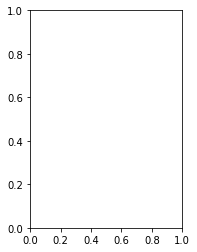

In [60]:
np.random.seed(0)
D=np.random.randn(1000,500)
hidden_layer_sizes=[500]*10
Hs={}
for i in range(len(hidden_layer_sizes)):
    X=D if i == 0 else Hs[i-1] 
    fan_in=X.shape[1]
    fan_out=hidden_layer_sizes[i]

#     w=np.random.randn(fan_in,fan_out)*0.01
#     w=np.random.randn(fan_in,fan_out) # 평균0, 표준편차1
#     w=np.random.randn(fan_in,fan_out)/np.sqrt(fan_in)  # --> tanh와 해야한다. Relu와 하면 잘 안됨
    w=np.random.randn(fan_in,fan_out)/np.sqrt(fan_in/2) # He.et 표준정규분포를 표준편차로 나눈 것을 또 2로 나눔
    
    H=np.dot(X,w)
    H=np.tanh(H) # tanh는 양수면1, 음수면 -1에 가깝게 출력되고, sigmoid는 0에서 좀만 커지면 1 아니면0으로 출력된다
    Hs[i]=H
    
print("입력계층 평균 %f and 표준편차 %f" % (np.mean(D),np.std(D)))
layer_means=[np.mean(H) for i,H in Hs.items()] # key, value 리턴
layer_stds=[np.std(H) for i,H in Hs.items()]


for i,H in Hs.items():
    print("히든 계층 %d 평균 %f and 표준편차 %f" % (i+1, layer_means[i], layer_stds[i]) )

    
plt.figure()
plt.subplot(121)
plt.plot(Hs.keys(), layer_means, 'ob-')
plt.xlabel('layer')
plt.title('layer_mean')


plt.subplot(122)
plt.plot(Hs.keys(), layer_stds, 'ob-')
plt.xlabel('layer')
plt.title('layer_std')
# layer가 늘어날수록 가중치가 0에 가까워져 제대로 된 결과를 얻을 수 없음

plt.figure()
for i,H in Hs.items():
    plt.subplot(1,len(Hs),i+1)
    plt.hist(H.ravel(),40, range(-1,1))
    plt.xlabel('layer'+str(i+1))
plt.show()

In [ ]:
결론 : 가우시안분포(종모양)에서 점점 0으로 수렴하므로 0에 가까운 선하나만 출력된다(소멸된다)

In [ ]:
방법2) 평균0, 표준편차 1인 

In [ ]:
Bagging : 복원추출 / 병렬 학습
Boosting : 복원추출 + 가중치 / 순차적 학습(data학습을 통해 나온 가중치를 분배한다)


In [13]:
import random
from tensorflow.examples.tutorials.mnist import input_data

In [25]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [20]:
learning_rate=0.001
training_epochs=15
batch_size=100

In [22]:
tf.reset_default_graph() # 그래프에 있는 모든 텐서를 초기화 --> 다른 텐서 실행했다면 충돌하므로 수행해준다
x=tf.placeholder(tf.float32,[None,784])
y=tf.placeholder(tf.float32,[None,10])

w1=tf.get_variable("w1",shape=[784,256],initializer=tf.contrib.layers.xavier_initializer())
b1=tf.Variable(tf.random_normal([256]))
L1=tf.nn.relu(tf.matmul(x,w1)+b1)

w2=tf.get_variable("w2",shape=[256,256],initializer=tf.contrib.layers.xavier_initializer())
b2=tf.Variable(tf.random_normal([256]))
L2=tf.nn.relu(tf.matmul(L1,w2)+b2)

w3=tf.get_variable("w3",shape=[256,10],initializer=tf.contrib.layers.xavier_initializer())
b3=tf.Variable(tf.random_normal([10]))
L3=tf.nn.relu(tf.matmul(L2,w3)+b3)

hf=tf.matmul(L2,w3)+b3

cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hf,labels=y))

train=tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [28]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(training_epochs): # 5만개 이미지 * 15번 트레이닝
        avg_cost=0
        total_batch=int(mnist.train.num_examples / batch_size) # 5만/100
        for i in range(total_batch): # 500번(1번에 100개씩 이미지를 읽겠다) => for문이 한번 다 돌면 에폭 1
            batch_xs, batch_ys=mnist.train.next_batch(batch_size) #이미지 100개씩 읽어오기 
            # batch_xs=[100,784], batch_ys=[100,10]
            myfeed={x:batch_xs,y:batch_ys}
            cv,_=sess.run([cost,train], feed_dict=myfeed) # cv는 100개의 데이터에 대한 cost
            avg_cost+=cv/total_batch #100개 데이터 cost/500
        print("Epoch:","%4d" % (epoch+1),'cost:','{:.9f}'.format(avg_cost))
#     print("learning finished")
#     print("accuarcy:" ,sess.run(accuracy, feed_dict={x:mnist.test.images,y:mnist.test.labels}))
c_pre=tf.equal(tf.argmax(hf,1),tf.argmax(y,1))
acc=tf.reduce_mean(tf.cast(c_pre,tf.float32))
print("acc:",sess.run(acc,feed_dict={x:mnist.test.images,y:mnist.test.labels}))

Epoch:    1 cost: 0.298860819
Epoch:    2 cost: 0.111154928
Epoch:    3 cost: 0.073004453
Epoch:    4 cost: 0.051895922
Epoch:    5 cost: 0.040271484
Epoch:    6 cost: 0.028815356
Epoch:    7 cost: 0.022476952
Epoch:    8 cost: 0.018433381
Epoch:    9 cost: 0.016797118
Epoch:   10 cost: 0.015668569
Epoch:   11 cost: 0.014306479
Epoch:   12 cost: 0.008617795
Epoch:   13 cost: 0.010974923
Epoch:   14 cost: 0.014094332
Epoch:   15 cost: 0.007411794
acc: 0.9749


In [31]:
tf.reset_default_graph() # 그래프에 있는 모든 텐서를 초기화 --> 다른 텐서 실행했다면 충돌하므로 수행해준다
x=tf.placeholder(tf.float32,[None,784])
y=tf.placeholder(tf.float32,[None,10])

w1=tf.get_variable("w1",shape=[784,512],initializer=tf.contrib.layers.xavier_initializer())
b1=tf.Variable(tf.random_normal([512]))
L1=tf.nn.relu(tf.matmul(x,w1)+b1)

w2=tf.get_variable("w2",shape=[512,512],initializer=tf.contrib.layers.xavier_initializer())
b2=tf.Variable(tf.random_normal([512]))
L2=tf.nn.relu(tf.matmul(L1,w2)+b2)

w3=tf.get_variable("w3",shape=[512,512],initializer=tf.contrib.layers.xavier_initializer())
b3=tf.Variable(tf.random_normal([512]))
L3=tf.nn.relu(tf.matmul(L2,w3)+b3)

w4=tf.get_variable("w4",shape=[512,512],initializer=tf.contrib.layers.xavier_initializer())
b4=tf.Variable(tf.random_normal([512]))
L4=tf.nn.relu(tf.matmul(L3,w4)+b4)

w5=tf.get_variable("w5",shape=[512,10],initializer=tf.contrib.layers.xavier_initializer())
b5=tf.Variable(tf.random_normal([10]))
L5=tf.nn.relu(tf.matmul(L4,w5)+b5)
hf=tf.matmul(L4,w5)+b5

cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hf,labels=y))

train=tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [32]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(training_epochs): # 5만개 이미지 * 15번 트레이닝
        avg_cost=0
        total_batch=int(mnist.train.num_examples / batch_size) # 5만/100
        for i in range(total_batch): # 500번(1번에 100개씩 이미지를 읽겠다) => for문이 한번 다 돌면 에폭 1
            batch_xs, batch_ys=mnist.train.next_batch(batch_size) #이미지 100개씩 읽어오기 
            # batch_xs=[100,784], batch_ys=[100,10]
            myfeed={x:batch_xs,y:batch_ys}
            cv,_=sess.run([cost,train], feed_dict=myfeed) # cv는 100개의 데이터에 대한 cost
            avg_cost+=cv/total_batch #100개 데이터 cost/500
        print("Epoch:","%4d" % (epoch+1),'cost:','{:.9f}'.format(avg_cost))
#     print("learning finished")
#     print("accuarcy:" ,sess.run(accuracy, feed_dict={x:mnist.test.images,y:mnist.test.labels}))
c_pre=tf.equal(tf.argmax(hf,1),tf.argmax(y,1))
acc=tf.reduce_mean(tf.cast(c_pre,tf.float32))
print("acc:",sess.run(acc,feed_dict={x:mnist.test.images,y:mnist.test.labels}))

Epoch:    1 cost: 0.301886335
Epoch:    2 cost: 0.107392004
Epoch:    3 cost: 0.075444499
Epoch:    4 cost: 0.053973506
Epoch:    5 cost: 0.044121138
Epoch:    6 cost: 0.032899671
Epoch:    7 cost: 0.031268230
Epoch:    8 cost: 0.027961754
Epoch:    9 cost: 0.021778238
Epoch:   10 cost: 0.022377897
Epoch:   11 cost: 0.017856162
Epoch:   12 cost: 0.017786008
Epoch:   13 cost: 0.016541631
Epoch:   14 cost: 0.015126533
Epoch:   15 cost: 0.012891133
acc: 0.9828


In [31]:
tf.reset_default_graph() # 그래프에 있는 모든 텐서를 초기화 --> 다른 텐서 실행했다면 충돌하므로 수행해준다
x=tf.placeholder(tf.float32,[None,784])
y=tf.placeholder(tf.float32,[None,10])

w1=tf.get_variable("w1",shape=[784,512],initializer=tf.contrib.layers.xavier_initializer())
b1=tf.Variable(tf.random_normal([512]))
L1=tf.nn.relu(tf.matmul(x,w1)+b1)

w2=tf.get_variable("w2",shape=[512,512],initializer=tf.contrib.layers.xavier_initializer())
b2=tf.Variable(tf.random_normal([512]))
L2=tf.nn.relu(tf.matmul(L1,w2)+b2)

w3=tf.get_variable("w3",shape=[512,512],initializer=tf.contrib.layers.xavier_initializer())
b3=tf.Variable(tf.random_normal([512]))
L3=tf.nn.relu(tf.matmul(L2,w3)+b3)

w4=tf.get_variable("w4",shape=[512,512],initializer=tf.contrib.layers.xavier_initializer())
b4=tf.Variable(tf.random_normal([512]))
L4=tf.nn.relu(tf.matmul(L3,w4)+b4)

w5=tf.get_variable("w5",shape=[512,10],initializer=tf.contrib.layers.xavier_initializer())
b5=tf.Variable(tf.random_normal([10]))
L5=tf.nn.relu(tf.matmul(L4,w5)+b5)
hf=tf.matmul(L4,w5)+b5

cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hf,labels=y))

train=tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [32]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(training_epochs): # 5만개 이미지 * 15번 트레이닝
        avg_cost=0
        total_batch=int(mnist.train.num_examples / batch_size) # 5만/100
        for i in range(total_batch): # 500번(1번에 100개씩 이미지를 읽겠다) => for문이 한번 다 돌면 에폭 1
            batch_xs, batch_ys=mnist.train.next_batch(batch_size) #이미지 100개씩 읽어오기 
            # batch_xs=[100,784], batch_ys=[100,10]
            myfeed={x:batch_xs,y:batch_ys}
            cv,_=sess.run([cost,train], feed_dict=myfeed) # cv는 100개의 데이터에 대한 cost
            avg_cost+=cv/total_batch #100개 데이터 cost/500
        print("Epoch:","%4d" % (epoch+1),'cost:','{:.9f}'.format(avg_cost))
#     print("learning finished")
#     print("accuarcy:" ,sess.run(accuracy, feed_dict={x:mnist.test.images,y:mnist.test.labels}))
c_pre=tf.equal(tf.argmax(hf,1),tf.argmax(y,1))
acc=tf.reduce_mean(tf.cast(c_pre,tf.float32))
print("acc:",sess.run(acc,feed_dict={x:mnist.test.images,y:mnist.test.labels}))

Epoch:    1 cost: 0.301886335
Epoch:    2 cost: 0.107392004
Epoch:    3 cost: 0.075444499
Epoch:    4 cost: 0.053973506
Epoch:    5 cost: 0.044121138
Epoch:    6 cost: 0.032899671
Epoch:    7 cost: 0.031268230
Epoch:    8 cost: 0.027961754
Epoch:    9 cost: 0.021778238
Epoch:   10 cost: 0.022377897
Epoch:   11 cost: 0.017856162
Epoch:   12 cost: 0.017786008
Epoch:   13 cost: 0.016541631
Epoch:   14 cost: 0.015126533
Epoch:   15 cost: 0.012891133
acc: 0.9828


In [ ]:
drop out : 매 층에서 특징을 추출하여 학습

In [34]:
tf.reset_default_graph() # 그래프에 있는 모든 텐서를 초기화 --> 다른 텐서 실행했다면 충돌하므로 수행해준다
x=tf.placeholder(tf.float32,[None,784])
y=tf.placeholder(tf.float32,[None,10])

keep_prob=tf.placeholder(tf.float32)

w1=tf.get_variable("w1",shape=[784,512],initializer=tf.contrib.layers.xavier_initializer())
b1=tf.Variable(tf.random_normal([512]))
L1=tf.nn.relu(tf.matmul(x,w1)+b1)
L1=tf.nn.dropout(L1,keep_prob=keep_prob)

w2=tf.get_variable("w2",shape=[512,512],initializer=tf.contrib.layers.xavier_initializer())
b2=tf.Variable(tf.random_normal([512]))
L2=tf.nn.relu(tf.matmul(L1,w2)+b2)
L2=tf.nn.dropout(L2,keep_prob=keep_prob)

w3=tf.get_variable("w3",shape=[512,512],initializer=tf.contrib.layers.xavier_initializer())
b3=tf.Variable(tf.random_normal([512]))
L3=tf.nn.relu(tf.matmul(L2,w3)+b3)
L3=tf.nn.dropout(L3,keep_prob=keep_prob)

w4=tf.get_variable("w4",shape=[512,512],initializer=tf.contrib.layers.xavier_initializer())
b4=tf.Variable(tf.random_normal([512]))
L4=tf.nn.relu(tf.matmul(L3,w4)+b4)
L4=tf.nn.dropout(L4,keep_prob=keep_prob)

w5=tf.get_variable("w5",shape=[512,10],initializer=tf.contrib.layers.xavier_initializer())
b5=tf.Variable(tf.random_normal([10]))
L5=tf.nn.relu(tf.matmul(L4,w5)+b5)
hf=tf.matmul(L4,w5)+b5

cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hf,labels=y))

train=tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [35]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(training_epochs): # 5만개 이미지 * 15번 트레이닝
        avg_cost=0
        total_batch=int(mnist.train.num_examples / batch_size) # 5만/100
        for i in range(total_batch): # 500번(1번에 100개씩 이미지를 읽겠다) => for문이 한번 다 돌면 에폭 1
            batch_xs, batch_ys=mnist.train.next_batch(batch_size) #이미지 100개씩 읽어오기 
            # batch_xs=[100,784], batch_ys=[100,10]
            myfeed={x:batch_xs,y:batch_ys,keep_prob:0.7}
            cv,_=sess.run([cost,train], feed_dict=myfeed) # cv는 100개의 데이터에 대한 cost
            avg_cost+=cv/total_batch #100개 데이터 cost/500
        print("Epoch:","%4d" % (epoch+1),'cost:','{:.9f}'.format(avg_cost))
#     print("learning finished")
#     print("accuarcy:" ,sess.run(accuracy, feed_dict={x:mnist.test.images,y:mnist.test.labels}))
c_pre=tf.equal(tf.argmax(hf,1),tf.argmax(y,1)) 
acc=tf.reduce_mean(tf.cast(c_pre,tf.float32))
print("acc:",sess.run(acc,feed_dict={x:mnist.test.images,y:mnist.test.labels,keep_prob:1})) # 실행할 때에는, keep_prob값을 1로 줘야한다

Epoch:    1 cost: 0.459282274
Epoch:    2 cost: 0.169935594
Epoch:    3 cost: 0.128616756
Epoch:    4 cost: 0.107031673
Epoch:    5 cost: 0.092420008
Epoch:    6 cost: 0.083330294
Epoch:    7 cost: 0.078245563
Epoch:    8 cost: 0.066661082
Epoch:    9 cost: 0.061973834
Epoch:   10 cost: 0.060018321
Epoch:   11 cost: 0.055969995
Epoch:   12 cost: 0.054765219
Epoch:   13 cost: 0.050063559
Epoch:   14 cost: 0.047913927
Epoch:   15 cost: 0.048316889
acc: 0.9828


In [ ]:
convolutional계층(합성곱)은 형상을 유지하는 계층이다
합성곱계층의 입력은 특징입력맵 출력은 특징출력맵이라고 한다
합성곱연산이란 ? element wide product를 수행하는 것

In [ ]:
입력data 
출력data=필터(or 커널): 신경망에선 weight의 역할을 한다
        윈도우란 입력데이터층에서 필터가 씌여지는 부분
--> 합성곱을 수행(stride:우측 아래로 스캐닝하듯이) 하면 입력data 위에 필터를 겹쳐 올려서 합성곱을 수행한다
--> 합성곱의 결과는 필터에서 뽑아내는 특징과 관련된 특징값이다.
    ex) 얼굴(입력data)에 주름추출filter를 사용해서 얻어지는 값은 주름에 대한 특징 값이다.
이때, CNN 기법을 사용하면 계산량이 확연하게 줄어든다.

In [ ]:
윈도우를 얼만큼씩 이동시킬지(stride)는 프로그래머가 결정해주어야한다.
입력data size(N*N)이고 윈도우 사이즈가 (m*m)일때, stride=s면
결과data size 는 N-m/(s)+1로 구한다.

In [ ]:
 y=wx+b에서 
    w: 입력신호가 출력 결과에 주는 영향도를 조절하는 변수
    b: 뉴런이 얼마나 쉽게 활성화 되느냐를 나타내는 매개 변수(편향)
        
ex) 윈도우 3*3일때, 가중치:9이고 편향:1이다. 
    커널(필터)의 값은 모든 윈도우에 공통으로 적용된다.
    필터 => 어떤 특징이 해당 영역(윈도우)에 있는지 없는지를 검출하는 함수
    

In [ ]:
maxpooling:특징이 가장 크게 드러나게 하는 

In [ ]:
padding: 필터주변을 특정값으로 채워주는 것(패딩1=두께1인 패딩) 
    --> 출력에 대한 크기를 조정하기 위한 용도이다(합성곱 수행할 수록 크기가 작아지기 때문이다)

In [ ]:
stride:출력 크기 간격
    stride가 크면, 출력 크기가 줄어들고
    padding이 크면, 출력 크기가 커진다
    
입력크기(H,W) 출력크기(OH,OW) 필터크기(FH,FW) 패팅크기(P*P) stride S일 때,
일반적인 관계식
OH=(H+2P-FH)/S+1
OW=(W+2P-FW)/S+1

In [ ]:
pooling도 크기를 결정해주어야한다

In [36]:
learning_rate=0.001
training_epochs=15
batch_size=100

In [42]:
tf.reset_default_graph() 

x=tf.placeholder(tf.float32,[None,28*28])
ximg=tf.reshape(x,[-1,28,28,1]) # black/white이므로 맨뒤에 1임 
y=tf.placeholder(tf.float32,[None,10])

w1=tf.Variable(tf.random_normal([3,3,1,32])) # 3행*3렬*1뎁쓰의 필터를 32개 사용
L1=tf.nn.conv2d(ximg,w1,strides=[1,1,1,1],padding="SAME")  # stride=[1,a,b,1]에서 맨끝의 1은 고정이고, a는 좌우로 움직이는 크기 b는 아래로 움직이는 크기
L1=tf.nn.relu(L1)
L1=tf.nn.max_pool(L1,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME") # 2*2의 풀링하려는 행렬을 만듬
# L1이미지 ?*28*28*1
# conv--> (?,28,28,32)
# pooling-->(?,14,14,32)

w2=tf.Variable(tf.random_normal([3,3,32,64])) # 3행*3렬*1뎁쓰의 필터를 32개 사용
L2=tf.nn.conv2d(L1,w2,strides=[1,1,1,1],padding="SAME")  # stride=[1,a,b,1]에서 맨끝의 1은 고정이고, a는 좌우로 움직이는 크기 b는 아래로 움직이는 크기
L2=tf.nn.relu(L2)
L2=tf.nn.max_pool(L2,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME") # 2*2의 풀링하려는 행렬을 만듬
# conv2d-->(?,14,14,64)
# relu-->(?,14,14,64)
# max_pool-->(?,7,7,64)

L2_flat=tf.reshape(L2,[-1,7*7*64])
# reshape-->(?,7*7*64)

w3=tf.get_variable("w3",shape=[7*7*64,10], initializer=tf.contrib.layers.xavier_initializer())

b=tf.Variable(tf.random_normal([10]))
logits=(tf.matmul(L2_flat,w3)+b)
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))
train=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


# tf.Variable(tf.random_normal([3,3,1,32])) # 3행*3렬*1뎁쓰의 필터를 32개 사용
# L1=tf.nn.conv2d(ximg,w1,strides=[1,1,1,1],padding="SAME")  # stride=[1,a,b,1]에서 맨끝의 1은 고정이고, a는 좌우로 움직이는 크기 b는 아래로 움직이는 크기
# L1=tf.nn.relu(L1)
# L1=tf.nn.max_pool(L1,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME") # 2*2의 풀링하려는 행렬을 만듬

In [45]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(training_epochs): # 5만개 이미지 * 15번 트레이닝
        avg_cost=0
        total_batch=int(mnist.train.num_examples / batch_size) # 5만/100
        for i in range(total_batch): # 500번(1번에 100개씩 이미지를 읽겠다) => for문이 한번 다 돌면 에폭 1
            batch_xs, batch_ys=mnist.train.next_batch(batch_size) #이미지 100개씩 읽어오기             
            myfeed={x:batch_xs,y:batch_ys}
            cv,_=sess.run([cost,train], feed_dict=myfeed) # cv는 100개의 데이터에 대한 cost
            avg_cost+=cv/total_batch #100개 데이터 cost/500
        print("Epoch:","%4d" % (epoch+1),'cost:','{:.9f}'.format(avg_cost))

c_pre=tf.equal(tf.argmax(logits,1),tf.argmax(y,1))
acc=tf.reduce_mean(tf.cast(c_pre,tf.float32))
print("acc:",sess.run(acc,feed_dict={x:mnist.test.images,y:mnist.test.labels})) # 실행할 때에는, keep_prob값을 1로 줘야한다

Epoch:    1 cost: 0.872398866
Epoch:    2 cost: 0.221885034
Epoch:    3 cost: 0.137596160
Epoch:    4 cost: 0.093039030
Epoch:    5 cost: 0.066833730
Epoch:    6 cost: 0.055998832
Epoch:    7 cost: 0.050047222
Epoch:    8 cost: 0.041411372
Epoch:    9 cost: 0.024919725
Epoch:   10 cost: 0.025519766
Epoch:   11 cost: 0.021879144
Epoch:   12 cost: 0.026323417
Epoch:   13 cost: 0.018063539
Epoch:   14 cost: 0.016202695
Epoch:   15 cost: 0.014912531
acc: 0.9851
